In [1]:
# !nvidia-smi
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # this MUST come before any tf call.

In [2]:
# !nvidia-smi

In [3]:
import numpy as np
import random
import tensorflow as tf

seed = 1337
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

2023-06-28 04:54:25.183593: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import difflib
import os
import shutil
import ants
import nibabel as nib
import cv2
import scipy.spatial
from glob import glob
from typing import  List
from pprint import pprint  
import json
from skimage.transform import resize
import matplotlib.pyplot as plt
import warnings
import scipy
from datetime import datetime
import SimpleITK as sitk

### Functions to get features of images

In [5]:
import SimpleITK as sitk
import scipy
def volume(img: sitk.Image):
    """
    Compute the volume of a binary image.

    Args:
        img (sitk.Image): The input binary image.

    Returns:
        float: The computed volume of the binary image.
    """
    array = sitk.GetArrayFromImage(img)
    pixel_volume = img.GetSpacing()[0] * img.GetSpacing()[1] * img.GetSpacing()[2]
    return (array > 0).sum() * pixel_volume

def mean(img: sitk.Image):
    """
    Compute the mean intensity value of an image.
    Args:
        img (sitk.Image): The input image for which the mean intensity value is to be computed.

    Returns:
        float: The mean intensity value of the input image.
    """
    f = sitk.StatisticsImageFilter()
    f.Execute(img)
    return f.GetMean()

def max(img: sitk.Image):
    """
    Compute the maximum intensity value of an image.
    Args:
        img (sitk.Image): The input image for which the maximum intensity value is to be computed.

    Returns:
        float: The maximum intensity value of the input image.
    """
    f = sitk.StatisticsImageFilter()
    f.Execute(img)
    return f.GetMaximum()

def median(img: sitk.Image):
    """
    Compute the median intensity value of an image.
    Args:
        img (sitk.Image): The input image for which the median intensity value is to be computed.

    Returns:
        float: The median intensity value of the input image.
    """
    f = sitk.StatisticsImageFilter()
    f.Execute(img)
    return f.GetMean()

def min(img: sitk.Image):
    """
    Compute the minimum intensity value of an image.
    Args:
        img (sitk.Image): The input image for which the minimum intensity value is to be computed.

    Returns:
        float: The minimum intensity value of the input image.
    """
    f = sitk.StatisticsImageFilter()
    f.Execute(img)
    return f.GetMinimum()

def sum(img: sitk.Image):
    """
    Compute the sum of intensity values in an image.
    Args:
        img (sitk.Image): The input image for which the sum of intensity values is to be computed.

    Returns:
        float: The sum of intensity values in the input image.
    """
    f = sitk.StatisticsImageFilter()
    f.Execute(img)
    return f.GetSum()

def variance(img: sitk.Image):
    """
    Compute the variance of intensity values in an image.
    Args:
        img (sitk.Image): The input image for which the variance of intensity values is to be computed.

    Returns:
        float: The variance of intensity values in the input image.

    """
    f = sitk.StatisticsImageFilter()
    f.Execute(img)
    return f.GetVariance()

def RegionalMaxima_(img: sitk.Image):
    """
    Compute the sum of regional maxima in an image.
    Args:
        img (sitk.Image): The input image on which regional maxima are to be detected.

    Returns:
        int: The sum of regional maxima in the input image.

    """
    transformed = sitk.RegionalMaxima(img)

    f = sitk.StatisticsImageFilter()
    f.Execute(transformed)
    return f.GetSum()

def ZeroCrossing_(img: sitk.Image):
    """
    Compute the sum of zero crossings in an image.
    Args:
        img (sitk.Image): The input image on which zero crossings are to be detected.

    Returns:
        int: The sum of zero crossings in the input image.

    """
    transformed = sitk.ZeroCrossing(img)
    f = sitk.StatisticsImageFilter()
    f.Execute(transformed)
    return f.GetSum()

def Derivative_(img: sitk.Image):
    """
    Compute the sum of image gradients using derivative filter.

    Args:
        img (sitk.Image): The input image on which gradients are to be computed.

    Returns:
        float: The sum of gradients of the input image.

    """
    transformed = sitk.Derivative(img)
    array = sitk.GetArrayFromImage(transformed)
    f = sitk.StatisticsImageFilter()
    f.Execute(transformed)
    return f.GetSum()

def GradientMagnitudeRecursiveGaussian_(img: sitk.Image):
    """
    Compute the sum of the gradient magnitude of an image using the GradientMagnitudeRecursiveGaussian filter.

    Args:
        img (sitk.Image): The input image on which the gradient magnitude is to be computed.

    Returns:
        float: The sum of the gradient magnitude of the input image.

    """
    transformed = sitk.GradientMagnitudeRecursiveGaussian(img)
    array = sitk.GetArrayFromImage(transformed)

    f = sitk.StatisticsImageFilter()
    f.Execute(transformed)
    return f.GetSum()

def MorphologicalWatershed_(img: sitk.Image):
    """
    Compute the sum of the morphological watershed transform of an image.
    The morphological watershed transform segments the image based on the regional
    minima, which are the lowest intensity points surrounded by higher intensity values.

    Args:
        img (sitk.Image): The input image on which the morphological watershed transform is to be computed.

    Returns:
        float: The sum of the morphological watershed transform.

    """
    transformed = sitk.MorphologicalWatershed(img)
    array = sitk.GetArrayFromImage(transformed)

    f = sitk.StatisticsImageFilter()
    f.Execute(transformed)
    return f.GetSum()

def ObjectnessMeasure_(img: sitk.Image):
    """
    Compute the sum of the objectness measure of an image.
    The objectness measure highlights structures of interest in the image and can be used for vessel enhancement and detection.

    Args:
        img (sitk.Image): The input image on which the objectness measure is to be computed.

    Returns:
        float: The sum of the objectness measure.

    """
    transformed = sitk.ObjectnessMeasure(img)
    array = sitk.GetArrayFromImage(transformed)

    f = sitk.StatisticsImageFilter()
    f.Execute(transformed)
    return f.GetSum()

def Toboggan_(img: sitk.Image):
    """
    Compute the sum of the Toboggan filter applied to the input image.

    The Toboggan filter enhances linear structures in an image. It is particularly useful for enhancing blood vessels in medical images.

    Args:
        img (sitk.Image): The input image to which the Toboggan filter is applied.

    Returns:
        float: The sum of the resulting image after applying the Toboggan filter.

    """
    transformed = sitk.Toboggan(img)
    array = sitk.GetArrayFromImage(transformed)

    f = sitk.StatisticsImageFilter()
    f.Execute(transformed)
    return f.GetSum()

def ZeroCrossingBasedEdgeDetection_(img: sitk.Image):
    """
    Compute the sum of the ZeroCrossingBasedEdgeDetection filter applied to the input image.
    The ZeroCrossingBasedEdgeDetection filter enhances edges and boundaries in an image.

    Args:
        img (sitk.Image): The input image to which the ZeroCrossingBasedEdgeDetection filter is applied.

    Returns:
        float: The sum of the resulting image after applying the ZeroCrossingBasedEdgeDetection filter.

    """
    transformed = sitk.ZeroCrossingBasedEdgeDetection(img)
    array = sitk.GetArrayFromImage(transformed)

    f = sitk.StatisticsImageFilter()
    f.Execute(transformed)
    return f.GetSum()

def Z_(img: sitk.Image):
    """
    Calculate the Z-coordinate of the center of mass of the input image.

    The center of mass (centroid) is the point at which the image's mass is equally balanced in all directions.

    Args:
        img (sitk.Image): The input image.

    Returns:
        float: The Z-coordinate of the center of mass.

    """
    array = sitk.GetArrayFromImage(img)
    coords = scipy.ndimage.measurements.center_of_mass(array)
    return coords[0]

def X_(img: sitk.Image):
    """
    Calculate the X-coordinate of the center of mass of the input image.

    Args:
        img (sitk.Image): The input image.

    Returns:
        float: The X-coordinate of the center of mass.

    """
    array = sitk.GetArrayFromImage(img)
    coords = scipy.ndimage.measurements.center_of_mass(array)
    return coords[1]

def Y_(img: sitk.Image):
    """
    Calculate the Y-coordinate of the center of mass of the input image.

    Args:
        img (sitk.Image): The input image.

    Returns:
        float: The Y-coordinate of the center of mass.

    """
    array = sitk.GetArrayFromImage(img)
    coords = scipy.ndimage.measurements.center_of_mass(array)
    return coords[2]

fn = [volume,
      max,
      median,  #HC
      #min,  #por mascara minimo saldra 0 
      sum, # HC 
      variance,
      RegionalMaxima_, #HC
      ZeroCrossing_,  #HC
      mean, # HC
      #Derivative_, # constant value
      GradientMagnitudeRecursiveGaussian_,#HC
      MorphologicalWatershed_,
      ObjectnessMeasure_,  #HC
      Toboggan_,  #HC
      ZeroCrossingBasedEdgeDetection_ , #HC,
      Z_,
      X_,
      Y_
    ]


def get_feature_header():
    """
    Get the list of feature names.

    Returns:
        list: A list containing the names of the feature functions.

    """
    return [f.__name__ for f in fn]

def get_feature_vector(img : sitk.Image):
    """
    Compute a vector of features for an input image.

    This function takes a SimpleITK Image and calculates a vector of features by applying
    each of the feature functions in the 'fn' list to the input image.

    Args:
        img (sitk.Image): The input image.

    Returns:
        list: A list containing the computed features.

    """
    return [f(img) for f in fn]


## Feature extraction Lacunar and MCA examples

### lacunar and MCA Ids

In [1]:
LACUNAR_IDS = [
  'c0001s0004t01',
  'c0001s0005t01',
  'c0002s0001t01',
  'c0002s0002t01',
  'c0002s0003t01',
  'c0002s0004t01',
  'c0002s0005t01',
  'c0002s0008t01',
  'c0002s0014t01',
  'c0002s0022t01',
  'c0002s0024t01',#
  'c0003s0001t01',
  'c0003s0002t01',
  'c0003s0003t01',
  'c0003s0004t01',
  'c0003s0005t01',
  'c0003s0006t01',
  'c0003s0007t01',
  'c0003s0008t01',
  'c0003s0009t01',
  'c0003s0010t01',
  'c0003s0011t01',
  'c0003s0012t01',
  'c0003s0013t01',
  'c0003s0014t01',
  'c0003s0015t01',
  'c0003s0016t01',
  'c0003s0017t01',
  'c0003s0018t01',
  'c0003s0019t01',
  'c0003s0020t01',
  'c0003s0021t01',
  'c0003s0022t01',
  'c0003s0023t01',
  'c0003s0024t01',
  'c0003s0025t01',
  'c0003s0026t01',
  'c0003s0027t01',
  'c0003s0028t01',
  'c0003s0029t01',
  'c0003s0031t01',
  'c0003s0032t01',
  'c0003s0033t01',
  'c0003s0034t01',
  'c0003s0035t01',
  'c0003s0036t01',
  'c0003s0037t01',
  'c0003s0038t01',
  'c0003s0039t01',
  'c0003s0040t01',
  'c0003s0041t01',
  'c0003s0042t01',
  'c0003s0043t01',
  'c0003s0044t01',
  'c0003s0045t01',
  'c0003s0048t01',
  'c0003s0049t01',
  'c0003s0050t01',
  'c0003s0051t01',
  'c0003s0052t01',
  'c0003s0053t01',
  'c0003s0054t01',
  'c0003s0055t01',
  'c0003s0056t01',
  'c0004s0003t01',
  'c0004s0005t01',
  'c0004s0007t01',
  'c0004s0012t01',
  'c0004s0014t01',
  'c0004s0015t01',
  'c0004s0016t01',
  'c0004s0018t01',
  'c0004s0021t01',
  'c0004s0022t01',
  'c0004s0024t01',
  'c0004s0025t01',
  'c0004s0026t01',
  'c0004s0027t01',
  'c0004s0029t01',
  'c0004s0030t01',
  'c0004s0032t01',
  'c0004s0034t01',
  'c0005s0006t01',
  'c0005s0008t01',
  'c0005s0010t01',
  'c0005s0014t01',
  'c0005s0018t01',
  'c0005s0026t01',
  'c0005s0027t01',
  'c0005s0029t01',
  'c0005s0035t01',
  'c0005s0042t01',
  'c0005s0043t01',
  'c0005s0044t01',
  'c0005s0049t01',
  'c0006s0001t01',
  'c0006s0004t01',
  'c0006s0005t01',
  'c0006s0010t01',
  'c0006s0014t01',
  'c0006s0019t01',
  'c0006s0020t01',
  'c0007s0004t01',
  'c0007s0008t01',
  'c0007s0010t01',
  'c0007s0012t01',
  'c0007s0013t01',
  'c0007s0014t01',
  'c0007s0015t01',
  'c0007s0016t01',
  'c0007s0017t01',
  'c0007s0020t01',
  'c0007s0024t01',
  'c0007s0025t01',
  'c0007s0026t01',
  'c0007s0028t01',
  'c0007s0030t01',
  'c0007s0031t01',
  'c0007s0035t01',
  'c0007s0036t01',
  'c0008s0002t01',
  'c0008s0013t01',
  'c0008s0032t01',
  'c0009s0001t01',
  'c0009s0003t01',
  'c0009s0004t01',
  'c0010s0002t01',
  'c0010s0002t02',
  'c0010s0003t01',
  'c0010s0003t02',
  'c0010s0006t01',
  'c0010s0008t01',
  'c0010s0013t01',
  'c0010s0013t02',
  'c0010s0014t01',
  'c0010s0025t01',
  'c0010s0025t02',
  'c0010s0029t01',
  'c0010s0031t01',
  'c0010s0034t01',
  'c0010s0044t01',
  'c0010s0044t02',
  'c0010s0046t01',
  'c0011s0002t01',
  'c0011s0006t01',
  'c0011s0007t01',
  'c0011s0011t01',
  'c0011s0014t01',
  'c0011s0015t01',
]
MCA_IDS = [
  'c0001s0006t01',
  'c0001s0007t01',
  'c0001s0008t01',
  'c0002s0007t01',
  'c0002s0009t01',
  'c0002s0011t01',  
  'c0002s0012t01',
  'c0002s0013t01',
  'c0002s0015t01',
  'c0002s0018t01',
  'c0002s0019t01',
  'c0002s0020t01',
  'c0002s0021t01',
  'c0002s0025t01',  
  'c0003s0030t01',#
  'c0004s0001t01',
  'c0004s0002t01',
  'c0004s0009t01',
  'c0004s0010t01',
  'c0004s0011t01',
  'c0004s0013t01',
  'c0004s0019t01',
  'c0004s0020t01',
  'c0004s0031t01',
  'c0004s0033t01',
  'c0005s0003t01',
  'c0005s0007t01',
  'c0005s0009t01',
  'c0005s0013t01',
  'c0005s0017t01',
  'c0005s0021t01',
  'c0005s0024t01',
  'c0005s0030t01',
  'c0005s0036t01',
  'c0006s0007t01',
  'c0006s0008t01',
  'c0007s0001t01',
  'c0007s0002t01',
  'c0007s0003t01',
  'c0007s0005t01',
  'c0007s0006t01',
  'c0007s0007t01',
  'c0007s0018t01',
  'c0007s0019t01',
  'c0007s0021t01',
  'c0007s0023t01',
  'c0007s0027t01',
  'c0007s0029t01',
  'c0007s0032t01',
  'c0007s0033t01',
  'c0007s0034t01',
  'c0008s0001t01',
  'c0008s0003t01',
  'c0008s0006t01',
  'c0008s0007t01',
  'c0008s0008t01',
  'c0008s0009t01',
  'c0008s0010t01',
  'c0008s0011t01',
  'c0008s0012t01',
  'c0008s0014t01',
  'c0008s0015t01',
  'c0008s0016t01',
  'c0008s0017t01',
  'c0008s0018t01',
  'c0008s0019t01',
  'c0008s0020t01',
  'c0008s0021t01',
  'c0008s0022t01',
  'c0008s0023t01',
  'c0008s0024t01',
  'c0008s0025t01',
  'c0008s0026t01',
  'c0008s0027t01',
  'c0008s0028t01',
  'c0008s0029t01',
  'c0008s0030t01',
  'c0008s0031t01',
  'c0008s0033t01',
  'c0009s0002t01',
  'c0009s0005t01',
  'c0009s0006t01',
  'c0009s0007t01',
  'c0009s0008t01',
  'c0009s0009t01',
  'c0009s0010t01',
  'c0009s0011t01',
  'c0009s0012t01',
  'c0010s0001t01',
  'c0010s0004t01',
  'c0010s0005t01',
  'c0010s0005t02',
  'c0010s0007t01',
  'c0010s0018t01',
  'c0010s0020t01',
  'c0010s0020t02',
  'c0010s0021t01',
  'c0010s0024t01',
  'c0010s0032t01',
  'c0010s0037t01',
  'c0011s0001t01',
  'c0011s0003t01',
  'c0011s0004t01',
  'c0011s0005t01',
  'c0011s0008t01',
  'c0011s0009t01',
  'c0011s0012t01',
  'c0011s0013t01'
]

In [7]:
def list_splitter(list_to_split, ratio):
    """
    Splits a given list into two sublists based on the provided ratio.

    Args:
        list_to_split (list): The original list to be split.
        ratio (float): The ratio to determine the size of the first sublist.

    Returns:
        list: A list containing two sublists. The first sublist contains elements
              from the beginning of the original list up to the specified ratio,
              and the second sublist contains the remaining elements.

    """
    elements = len(list_to_split)
    middle = int(elements * ratio)
    return [list_to_split[:middle], list_to_split[middle:]]

In [8]:
LACUNAR_TRAIN, LACUNAR_TEST = list_splitter(LACUNAR_IDS, 0.8)
MCA_TRAIN, MCA_TEST = list_splitter(MCA_IDS, 0.8)

In [9]:
len(LACUNAR_TRAIN), len(LACUNAR_TEST)

(119, 30)

In [10]:
len(MCA_TRAIN), len(MCA_TEST)

(86, 22)

In [11]:
# LACUNAR_TEST

In [12]:
for id in LACUNAR_TRAIN:
    if id not in LACUNAR_IDS:
        print(id)

In [13]:
for id in MCA_TRAIN:
    if id not in MCA_IDS:
        print(id)

In [14]:
# MCA_TRAIN[:10]

In [15]:
# MCA_TEST[:10]

### Build csv

In [16]:
def id_from_path(path:str) -> str:
  """
    Extracts the file ID from a given file path.

    Args:
        path (str): The file path from which the ID needs to be extracted.

    Returns:
        str: The extracted file ID.
    """
  #may need to be updated if data location change
  return path.split('/')[-1]

In [17]:
base_path = '/home/carlos.jimenez/ai-in-health/Stroke-Brain-Lesions'
datasets_path = f'{base_path}/datasets/paper lesions extended'
models_path = f'{base_path}/modelos/paper lesions extended'
mni_T1_path = TEMPLATE_PATH = f'{base_path}/datasets/templates/mni_icbm152_t1_tal_nlin_sym_09a.nii'

In [18]:
from glob import glob
from pprint import pprint
path_proccesed_masked=f"{datasets_path}/native_processed_masked_best"

folders =  sorted(glob(f'{path_proccesed_masked}/*'))
print(len(folders))
# pprint(folders[:3])
# print(folders)
# folders

257


In [19]:
def id_from_path(path:str) -> str:
  """
    Extracts the file ID from a given file path.

    Args:
        path (str): The file path from which the ID needs to be extracted.

    Returns:
        str: The extracted file ID.

    """
  #may need to be updated if data location change
  return path.split('/')[-1][:-24]

In [20]:
#just MCA and lacunar
whole = MCA_IDS + LACUNAR_IDS
folders_filtered = [ f 
                    for f in folders 
                    if id_from_path(f) in whole]
len(folders_filtered)

257

In [21]:
'c0001s0004t01' in whole

True

In [22]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
'c0001s0004t01' in LACUNAR_IDS

True

In [23]:
from helpers import *

In [24]:
ximg = sitk.ReadImage(folders_filtered[-1], sitk.sitkFloat32)
# explore_3D_array(sitk.GetArrayFromImage(ximg))

In [25]:
id_from_path(folders_filtered[1])

'c0001s0005t01'

In [26]:
def save_slices(xpath, save_dir=None):
    """
    Extracts and saves slices from the input 3D medical image in three planes (sagittal, coronal, and axial) as separate image files.

    Args:
        xpath (str): The path to the 3D medical image file.
        save_dir (str, optional): The directory where the extracted slices will be saved. 
        If not provided, the slices will be saved in the same directory as the input image.

    """
    # Load the 3D medical image
    scan = nib.load(xpath)
    scanArray = scan.get_fdata()
    scanArrayShape = scanArray.shape
    id = id_from_path(xpath)

    
    # Save slices in the sagittal plane
    for i in range(scanArrayShape[0]):
        array = scanArray[i,:,:]
        if array.any():
            outputArray = cv2.resize(array, (scanArrayShape[2],scanArrayShape[1]))
            outputArray = cv2.rotate(outputArray, cv2.ROTATE_90_COUNTERCLOCKWISE)
            cv2.imwrite(f'{save_dir}/{id}_sag_{str(i+1)}.png', outputArray)
    
    # Save slices in the coronal plane
    for i in range(scanArrayShape[1]):
        array = scanArray[:,i,:]
        if array.any():
            outputArray = cv2.resize(array, (scanArrayShape[2],scanArrayShape[0]))
            outputArray = cv2.rotate(outputArray, cv2.ROTATE_90_COUNTERCLOCKWISE)
            cv2.imwrite(f'{save_dir}/{id}_cor_{str(i+1)}.png', outputArray)

    # Save slices in the axial plane
    for i in range(scanArrayShape[2]):
        array = scanArray[:,:,i]
        if array.any():
            outputArray = cv2.resize(array, (scanArrayShape[1],scanArrayShape[0]))
            outputArray = cv2.rotate(outputArray, cv2.ROTATE_90_CLOCKWISE)
            cv2.imwrite(f'{save_dir}/{id}_ax_{str(i+1)}.png', outputArray)

In [ ]:
# Iterate through the filtered folders and process each image
for i, xpath in enumerate(folders_filtered):
    # Read the image using SimpleITK
    ximg = sitk.ReadImage(xpath, sitk.sitkFloat32)
    img_volume = volume(ximg)
    # Define the paths for the classification dataset
    clf_train_dataset = f'{datasets_path}/DL_CLASSIFICATION_SLICES_BEST_MODEL/train'
    clf_test_dataset = f'{datasets_path}/DL_CLASSIFICATION_SLICES_BEST_MODEL/test'
    
    # Check if the image volume is greater than zero
    if img_volume > 0:
        id = id_from_path(xpath)

        # Determine the appropriate save directory based on the image ID and class
        if id in LACUNAR_TRAIN:
            save_dir = f'{clf_train_dataset}/LACUNAR'
        elif id in LACUNAR_TEST:
            save_dir = f'{clf_test_dataset}/LACUNAR'
        elif id in MCA_TRAIN:
            save_dir = f'{clf_train_dataset}/MCA'
        elif id in MCA_TEST:
            save_dir = f'{clf_test_dataset}/MCA'
        else:
            print(i, xpath)
            raise ValueError
            
        # Save the slices of the image to the appropriate directory
        save_slices(xpath, save_dir)

        print(f'{i} -> {save_dir}/{id}')
    else:
        print(f'volume {i} is zero: {xpath}')


In [42]:
# sitk_img = sitk.ReadImage('/home/carlos.jimenez/ai-in-health/Stroke-Brain-Lesions/datasets/paper lesions extended/DL_CLASSIFICATION/LACUNAR/train/c0001s0004t01_processed_masked.nii.gz', sitk.sitkFloat32)

In [20]:
# print(sitk_img)

In [42]:
save_path = f'{base_path}/datasets/template_slices'
# sitk_img = sitk.ReadImage(TEMPLATE_PATH, sitk.sitkFloat32)
save_slices(TEMPLATE_PATH, save_path)

The scan data array has the shape:  (197, 233, 189)
##### 0th ####
##### 1st ####
##### 2nd ####


The scan data array has the shape:  (197, 233, 189)


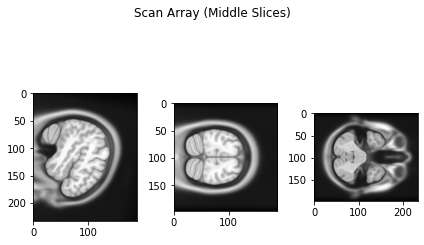

In [26]:
scanFilePath = TEMPLATE_PATH
 
#Load the scan and extract data using nibabel 
scan = nib.load(scanFilePath)
scanArray = scan.get_fdata()
 
#Get and print the scan's shape 
scanArrayShape = scanArray.shape
print('The scan data array has the shape: ', scanArrayShape)
 
#Get and print the scan's header
scanHeader = scan.header
# print('The scan header is as follows: \n', scanHeader)
 
#Display scan array's middle slices
fig, axs = plt.subplots(1,3)
fig.suptitle('Scan Array (Middle Slices)')
axs[0].imshow(scanArray[50,:,:], cmap='gray')
axs[1].imshow(scanArray[:,50,:], cmap='gray')
axs[2].imshow(scanArray[:,:,30], cmap='gray')
fig.tight_layout()
plt.show()

In [45]:
import os

base_path = '/home/carlos.jimenez/ai-in-health/Stroke-Brain-Lesions'
datasets_path = f'{base_path}/datasets/paper lesions extended'
models_path = f'{base_path}/modelos/paper lesions extended'
mni_T1_path = TEMPLATE_PATH = f'{base_path}/datasets/templates/mni_icbm152_t1_tal_nlin_sym_09a.nii'
clf_dataset_path = f'{datasets_path}/DL_CLASSIFICATION_SLICES_BEST_MODEL/train'

In [46]:
# Define the path to the 'LACUNAR' directory in the classification dataset
lacunar_train = os.listdir(f'{clf_dataset_path}/LACUNAR')
# Extract the image IDs from the filenames and store them in a list
lacunar_train_ids = [p.split('_')[0] for p in lacunar_train]
# Get the number of unique image IDs in the 'LACUNAR' directory
len(lacunar_train_ids)
# print(lacunar_train)

17879

In [47]:
mca_train = os.listdir(f'{clf_dataset_path}/MCA')
mca_train_ids = [p.split('_')[0] for p in mca_train]
len(mca_train_ids)

18568

In [8]:
for id in lacunar_train_ids:
    if id in mca_train_ids:
        print(id)

In [24]:
# import matplotlib.image as img
# import numpy as np

# for path in lacunar_train:
#     xpath = f'{clf_dataset_path}/Lacunar/{path}'
# #     print(xpath)
#     image = img.imread(xpath)
    
# #     print(img)
#     print(np.array(image).shape)

In [15]:
# import os
# import random
# import shutil

# source = f'{clf_dataset_path}/MCA'
# dest = f'{datasets_path}/MCA_TEST_EXTRAS'
# files = os.listdir(source)
# no_of_files = int(len(files) * 0.008)

# print(no_of_files)

# for file_name in random.sample(files, no_of_files):
#     shutil.move(os.path.join(source, file_name), dest)


23


In [61]:
17077 - 7684

9393